# Libraries

This code sets up the environment for training a neural network with illia on top of PyTorch. First, it makes sure illia uses the PyTorch backend. Then it imports the necessary illia layers, PyTorch modules for models and optimization, dataset utilities, and Matplotlib for plotting. With this setup, you can define a model, load data, train, and visualize results.

In [1]:
import sys
import os

# Configure Illia to use PyTorch as backend
os.environ["ILLIA_BACKEND"] = "torch"

import illia
from illia.nn import Conv2D, Linear

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

print(illia.__version__)
print(illia.__get_backend__)

0.2.1
torch


Here we choose whether to run the model on a GPU (CUDA) if available, or fall back to the CPU. This ensures the code adapts automatically to the hardware. We also print the selected device so it’s clear where computations will happen.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Here we prepare the MNIST dataset for training. First, we define transformations to convert images to tensors and normalize them. Then we load the training and test sets, downloading them if needed. Finally, we create data loaders that batch and shuffle the data for efficient training and evaluation.

In [3]:
# Define preprocessing: convert to tensor and normalize MNIST images
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # Mean and std of MNIST
    ]
)

# Load MNIST datasets (download if not already present)
train_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("data", train=False, transform=transform)

# Create data loaders for training and testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This defines a simple Convolutional Neural Network (CNN) for classifying MNIST digits. It has two bayesian convolutional layers, followed by two bayesian fully connected layers. Dropout is used to reduce overfitting. The forward pass applies convolution, ReLU, pooling, flattening, and finally outputs class probabilities with log-softmax. After defining the class, we create the model, move it to the selected device (CPU/GPU), and print the number of parameters.

In [4]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = Conv2D(1, 32, kernel_size=3, padding=1)
        self.conv2 = Conv2D(32, 64, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = Linear(64 * 7 * 7, 128)
        self.fc2 = Linear(128, 10)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv + ReLU + MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second conv + ReLU + MaxPool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected + dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Output log-probabilities
        return F.log_softmax(x, dim=1)


# Initialize the model and move to device
model = SimpleCNN().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 843284 parameters


Now we configure how the model will learn. The Adam optimizer updates the network’s parameters during training with a learning rate of 0.001. For the loss, we use Negative Log Likelihood (NLLLoss), which pairs with the log_softmax output from the model to measure prediction accuracy against true labels.

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

We define two functions: one for training (``train_epoch``) and one for evaluation (``test``).

During training, the model is set to training mode, gradients are reset, and each batch goes through forward pass, loss calculation, backward pass, and optimizer update. Loss and accuracy are tracked and periodically printed.

For evaluation, the model switches to evaluation mode and gradients are disabled for efficiency. Each batch is processed, loss is accumulated, and accuracy is computed on the test set. At the end, average loss and accuracy are reported.

In [6]:
# Training function for one epoch
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward and loss
        output = model(data)
        loss = criterion(output, target)

        # Backpropagation and update
        loss.backward()
        optimizer.step()

        # Track statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        # Print progress every 200 batches
        if batch_idx % 200 == 0:
            print(
                f"Batch {batch_idx}/{len(train_loader)}, "
                f"Loss: {loss.item():.6f}, "
                f"Accuracy: {100. * correct / total:.2f}%"
            )

    return total_loss / len(train_loader), 100.0 * correct / total


# Evaluation function
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():  # No gradients needed for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total

    print(f"\nTest Loss: {test_loss:.6f}, Test Accuracy: {accuracy:.2f}%\n")
    return test_loss, accuracy

We now run the training loop. For each epoch, the model is trained on the training set and then evaluated on the test set. Loss and accuracy are stored for later visualization. Progress is printed after every epoch, and at the end we confirm training is complete. In this example, training runs for 2 epochs.

In [7]:
# Training setup
num_epochs = 2
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_loss, test_acc = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Report epoch results
    print(
        f"Epoch {epoch + 1} - "
        f"Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.2f}%, "
        f"Test Acc: {test_acc:.2f}%"
    )

print("Training completed!")

Starting training...

Epoch 1/2
--------------------------------------------------
Batch 0/938, Loss: 3.542201, Accuracy: 9.38%
Batch 200/938, Loss: 0.405245, Accuracy: 83.38%
Batch 400/938, Loss: 0.096597, Accuracy: 89.36%
Batch 600/938, Loss: 0.062778, Accuracy: 91.73%
Batch 800/938, Loss: 0.162707, Accuracy: 93.07%

Test Loss: 0.043868, Test Accuracy: 98.52%

Epoch 1 - Train Loss: 0.206314, Train Acc: 93.69%, Test Acc: 98.52%
Epoch 2/2
--------------------------------------------------
Batch 0/938, Loss: 0.052432, Accuracy: 98.44%
Batch 200/938, Loss: 0.013136, Accuracy: 98.00%
Batch 400/938, Loss: 0.008689, Accuracy: 98.06%
Batch 600/938, Loss: 0.035820, Accuracy: 98.03%
Batch 800/938, Loss: 0.024955, Accuracy: 98.05%

Test Loss: 0.033828, Test Accuracy: 98.91%

Epoch 2 - Train Loss: 0.060348, Train Acc: 98.10%, Test Acc: 98.91%
Training completed!


After training, we can visualize predictions by passing a batch of test images through the model and showing the true vs. predicted labels. Next, we plot the training and test losses and accuracies over epochs to analyze performance. We then save the trained model to a file for later use and provide a helper function to load it. Finally, the last test accuracy is displayed as a summary of the model’s performance.

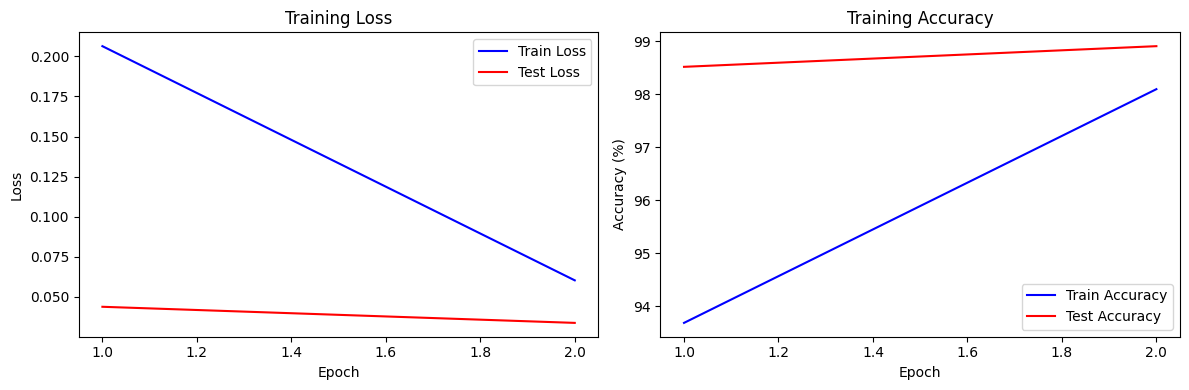

Visualizing some predictions...


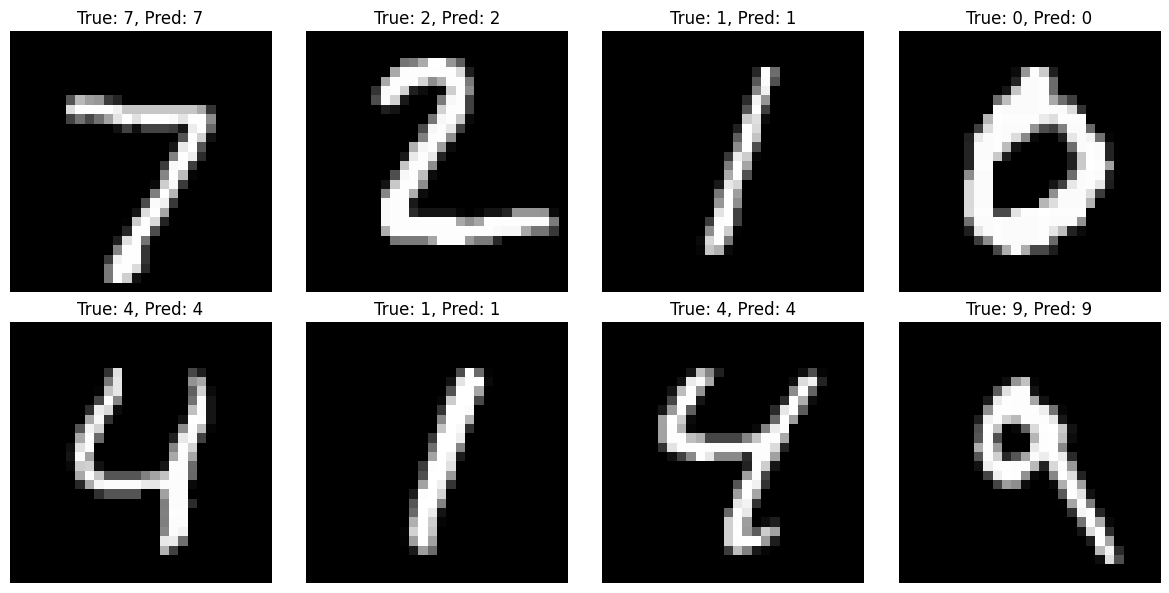

Model saved as 'mnist_cnn_model.pth'

Final result: 98.91% test accuracy


In [8]:
# Function to visualize predictions on test images
def visualize_predictions(model, test_loader, device, num_images=8):
    model.eval()
    data_iter = iter(test_loader)
    data, target = next(data_iter)
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        output = model(data)
        predictions = output.argmax(dim=1)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        img = data[i].cpu().squeeze()
        true_label = target[i].cpu().item()
        pred_label = predictions[i].cpu().item()

        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Plot training and test loss/accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, "b-", label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, "r-", label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, "b-", label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, "r-", label="Test Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# Show some predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)

# Save the trained model
torch.save(model.state_dict(), "mnist_cnn_model.pth")
print("Model saved as 'mnist_cnn_model.pth'")


# Function to load the saved model
def load_model():
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load("mnist_cnn_model.pth"))
    model.eval()
    return model


# Display final test accuracy
print(f"\nFinal result: {test_accuracies[-1]:.2f}% test accuracy")

This function loads a previously trained model from a file. It reconstructs the ``SimpleCNN``, loads the saved weights, moves the model to the appropriate device (CPU or GPU), sets it to evaluation mode, and prints a confirmation. This allows you to use the trained model later without retraining.

In [9]:
# Load a trained model from file
def load_trained_model(model_path="mnist_cnn_model.pth"):
    model = SimpleCNN().to(device)  # Recreate the model and move to device
    model.load_state_dict(
        torch.load(model_path, map_location=device)
    )  # Load saved weights
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {model_path}")
    return model

This function predicts the digit for a single MNIST image. It ensures the image tensor has the correct shape, moves it to the proper device, passes it through the model in evaluation mode, and returns the predicted class, the confidence of that prediction, and the full probability distribution over all classes. This is useful for testing individual images without using a DataLoader.

In [10]:
# Predict the digit of a single image
def predict_single_image(model, image_tensor):
    """
    image_tensor: tensor of shape (1, 28, 28) or (28, 28)
    Returns: predicted class, confidence, and probabilities
    """
    model.eval()

    # Ensure tensor has shape (1, 1, 28, 28)
    if image_tensor.dim() == 2:  # (28, 28)
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.dim() == 3:  # (1, 28, 28)
        image_tensor = image_tensor.unsqueeze(0)

    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.exp(output)  # Convert log_softmax to probabilities
        prediction = output.argmax(dim=1).item()
        confidence = probabilities.max().item()

    return prediction, confidence, probabilities.squeeze()

We take a single batch from the test loader, select one image, and visualize it. Since MNIST images are grayscale, we need to remove the channel dimension before plotting. This approach avoids using iter in a way that could conflict with overwritten names.

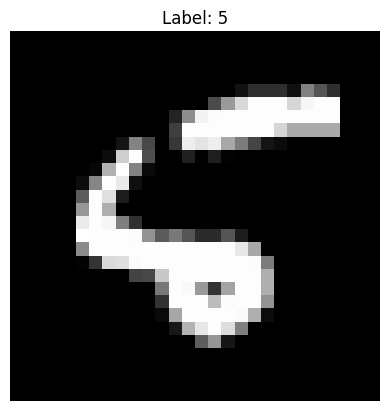

In [11]:
# Get one batch from the test loader
for data, target in test_loader:
    break  # just take the first batch

# Select an example image (index 8)
img_example = data[8]  # shape: (1, 28, 28)

# Remove channel dimension for plotting
img_to_plot = img_example.squeeze().cpu()  # shape: (28, 28)

# Display the image
plt.imshow(img_to_plot, cmap="gray")
plt.title(f"Label: {target[8].item()}")
plt.axis("off")
plt.show()

First, we load the previously trained model from file. Then, we run multiple predictions on a single MNIST image to collect probability distributions. This can be useful for analyzing model confidence or estimating uncertainty. Each prediction returns probabilities over all classes, and stacking them results in a matrix where each row is an iteration and each column is a class probability.

In [12]:
# 1. Load trained model
model = load_trained_model("mnist_cnn_model.pth")

# 2. Make multiple predictions on a single image
num_iter = 100
all_probabilities = []

for i in range(num_iter):  # avoid overwriting built-in 'iter'
    _, _, probabilities = predict_single_image(model, img_example)
    all_probabilities.append(probabilities)

# Stack results: each row = one iteration, each column = probability for a class
all_probabilities = np.vstack(all_probabilities)

Model loaded from mnist_cnn_model.pth


/tmp/ipykernel_51255/3600316336.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights


After collecting multiple predictions, we analyze the probability distributions. We compute the mean probability for each class and the 95% confidence interval using the 2.5th and 97.5th percentiles. A bar plot visualizes the mean probabilities, with error bars representing the confidence intervals. Printing the numerical values helps to inspect the model’s certainty for each class. This approach is useful to understand prediction stability or uncertainty for a single image.

Class 0: 0.000 [0.000, 0.000]
Class 1: 0.000 [0.000, 0.000]
Class 2: 0.000 [0.000, 0.000]
Class 3: 0.000 [0.000, 0.000]
Class 4: 0.000 [0.000, 0.000]
Class 5: 0.830 [0.812, 0.843]
Class 6: 0.011 [0.010, 0.012]
Class 7: 0.000 [0.000, 0.000]
Class 8: 0.157 [0.144, 0.174]
Class 9: 0.001 [0.001, 0.002]


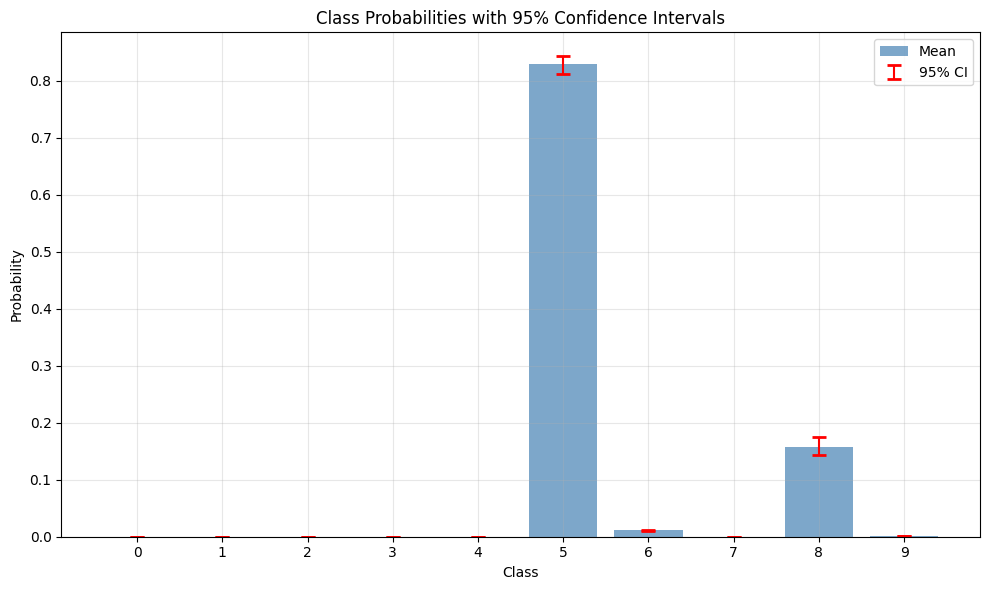

In [13]:
# Stack predictions (each row = one iteration, each column = class probability)
all_probabilities = np.vstack(all_probabilities)

# Compute statistics: mean and 95% confidence interval
mean_probs = np.mean(all_probabilities, axis=0)
lower_ci = np.percentile(all_probabilities, 2.5, axis=0)  # 2.5th percentile
upper_ci = np.percentile(all_probabilities, 97.5, axis=0)  # 97.5th percentile

# Plot mean probabilities with error bars
plt.figure(figsize=(10, 6))
classes = range(len(mean_probs))

plt.bar(classes, mean_probs, alpha=0.7, color="steelblue", label="Mean")

# Compute error bars
error_lower = np.abs(mean_probs - lower_ci)
error_upper = np.abs(upper_ci - mean_probs)

plt.errorbar(
    classes,
    mean_probs,
    yerr=[error_lower, error_upper],
    fmt="none",
    color="red",
    capsize=5,
    capthick=2,
    label="95% CI",
)

plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Class Probabilities with 95% Confidence Intervals")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(classes)

# Print values
for i, (mean_val, lower_val, upper_val) in enumerate(
    zip(mean_probs, lower_ci, upper_ci)
):
    print(f"Class {i}: {mean_val:.3f} [{lower_val:.3f}, {upper_val:.3f}]")

plt.tight_layout()
plt.show()